In [1]:
# Let's load and process the dataset
from fuel.datasets.dogs_vs_cats import DogsVsCats
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
from fuel.transformers.image import RandomFixedSizeCrop
from fuel.transformers.image import MinimumImageDimensions
from fuel.transformers import Flatten
from fuel.transformers import ScaleAndShift

In [2]:
# Load the training set
train = DogsVsCats(('train',), subset=slice(0, 20000))


In [3]:
from fuel.schemes import SequentialScheme

stream1 = DataStream(train,
                    iteration_scheme=SequentialScheme(train.num_examples,128))

stream2 = MinimumImageDimensions(stream1, (512,512), which_sources = ('image_features',))

In [133]:
first_original = next(stream1.get_epoch_iterator())
first_altered = next(stream2.get_epoch_iterator())

In [7]:
first_original[1][20:30]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=uint8)

In [17]:
first_altered[1][20:30]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=uint8)

In [134]:
shape_original = []
for image in first_original[0]:
    shape_original.append(image.shape)

In [141]:
shape_original

[(3, 375, 499),
 (3, 332, 500),
 (3, 319, 417),
 (3, 436, 451),
 (3, 223, 319),
 (3, 499, 471),
 (3, 500, 499),
 (3, 238, 499),
 (3, 377, 499),
 (3, 293, 500),
 (3, 500, 439),
 (3, 375, 499),
 (3, 355, 500),
 (3, 374, 500),
 (3, 374, 500),
 (3, 296, 399),
 (3, 496, 500),
 (3, 366, 500),
 (3, 377, 500),
 (3, 500, 396),
 (3, 402, 467),
 (3, 321, 460),
 (3, 356, 264),
 (3, 235, 280),
 (3, 500, 334),
 (3, 175, 235),
 (3, 500, 499),
 (3, 496, 301),
 (3, 486, 399),
 (3, 398, 499),
 (3, 500, 475),
 (3, 370, 441),
 (3, 304, 275),
 (3, 500, 407),
 (3, 500, 406),
 (3, 188, 249),
 (3, 375, 499),
 (3, 355, 325),
 (3, 500, 381),
 (3, 447, 276),
 (3, 385, 499),
 (3, 491, 439),
 (3, 335, 448),
 (3, 396, 499),
 (3, 424, 499),
 (3, 374, 500),
 (3, 375, 499),
 (3, 374, 500),
 (3, 399, 463),
 (3, 499, 406),
 (3, 406, 500),
 (3, 263, 349),
 (3, 240, 319),
 (3, 349, 326),
 (3, 499, 375),
 (3, 375, 499),
 (3, 239, 240),
 (3, 469, 382),
 (3, 363, 500),
 (3, 437, 499),
 (3, 260, 339),
 (3, 499, 306),
 (3, 239

In [20]:
shape_altered = []
for image in first_altered[0]:
    shape_altered.append(image.shape)

In [23]:
shape_altered[0:10]

[(3, 512, 682),
 (3, 512, 772),
 (3, 512, 670),
 (3, 512, 530),
 (3, 512, 733),
 (3, 543, 512),
 (3, 514, 512),
 (3, 512, 1074),
 (3, 512, 678),
 (3, 512, 874)]

In [12]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


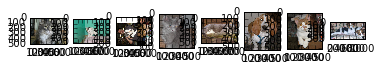

In [30]:
num_image = 8
for index in range(num_image):
    image = first_altered[0][index]
    plt.subplot(1,num_image,index+1)
    plt.imshow(image.transpose((1,2,0)))



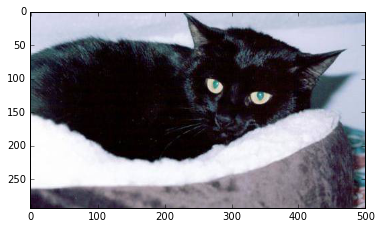

In [26]:
for image in first_original[0][1:10]:
    plt.imshow(image.transpose((1,2,0)))

In [31]:
from downscale_transformer import MaximumImageDimensions


In [39]:
stream3 = MaximumImageDimensions(stream1,(200,200),which_sources = ('image_features',))

In [40]:
first_downscaled = next(stream3.get_epoch_iterator())

In [41]:
first_downscaled[1][20:30]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=uint8)

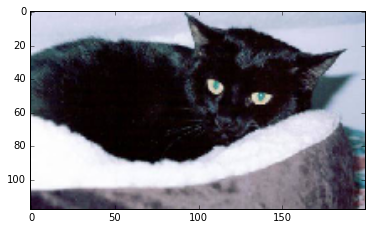

In [42]:
for image in first_downscaled[0][1:10]:
    plt.imshow(image.transpose((1,2,0)))

In [44]:
shape_downscaled = []
for image in first_downscaled[0]:
    shape_downscaled.append(image.shape)

In [47]:
shape_downscaled[0:10]

[(3, 151, 200),
 (3, 133, 200),
 (3, 153, 200),
 (3, 194, 200),
 (3, 140, 201),
 (3, 200, 189),
 (3, 200, 200),
 (3, 96, 200),
 (3, 152, 200),
 (3, 118, 200)]

In [48]:
stream4 = MaximumImageDimensions(stream2,(200,200),which_sources = ('image_features',))

In [49]:
first_upscaled_then_downscaled = next(stream4.get_epoch_iterator())

In [50]:
first_upscaled_then_downscaled[1][20:30]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=uint8)

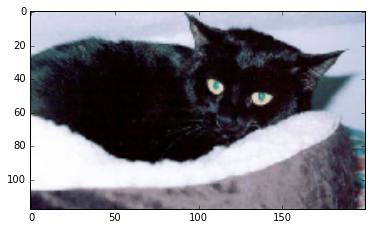

In [51]:
for image in first_upscaled_then_downscaled[0][1:10]:
    plt.imshow(image.transpose((1,2,0)))

In [52]:
shape_updownscaled = []
for image in first_upscaled_then_downscaled[0]:
    shape_updownscaled.append(image.shape)

In [53]:
shape_updownscaled[0:10]

[(3, 151, 200),
 (3, 133, 200),
 (3, 153, 200),
 (3, 194, 201),
 (3, 140, 200),
 (3, 200, 189),
 (3, 200, 200),
 (3, 96, 200),
 (3, 152, 200),
 (3, 118, 200)]

In [54]:
import timeit


In [62]:
%%time
for get in stream1.get_epoch_iterator():
    pass

CPU times: user 8.89 s, sys: 14.9 s, total: 23.8 s
Wall time: 29.9 s


In [63]:
%%time
for get in stream2.get_epoch_iterator():
    pass

CPU times: user 2min 46s, sys: 44.4 s, total: 3min 31s
Wall time: 3min 40s


In [64]:
%%time
for get in stream3.get_epoch_iterator():
    pass

CPU times: user 1min 57s, sys: 15.8 s, total: 2min 13s
Wall time: 2min 20s


In [65]:
%%time
for get in stream4.get_epoch_iterator():
    pass

CPU times: user 3min 13s, sys: 46.8 s, total: 3min 59s
Wall time: 4min 7s


In [66]:
from __future__ import division

50/3 in 

16.666666666666668

In [67]:
ran = (0,1)

In [73]:
(1,2)== "f"

False

In [4]:
from rescale_transformer import rescale_transformer

In [161]:
stream5 = rescale_transformer(stream1,1.5,256,which_sources= ('image_features',))
# Take random crops of (32 x 32) from each image
cropped_stream = RandomFixedSizeCrop(
    stream5, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
default_cropped_stream = ScaleAndShift(cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
default_flattened_stream = Flatten(
    default_cropped_stream, which_sources=('image_features',))



In [138]:
first_rescale = next(stream5.get_epoch_iterator())

In [140]:
shape_rescale = []
for image in first_rescale[0]:
    shape_rescale.append(image.shape)

In [145]:
same = 0
for index in range(len(shape_rescale)):
    same = same + (shape_rescale[index] == shape_original[index])

In [146]:
same

51

In [147]:
len(shape_rescale)

128

In [9]:
first_rescale[1][20:30]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=uint8)

In [164]:
%%time
for get in default_flattened_stream.get_epoch_iterator():
    pass

CPU times: user 28.7 s, sys: 15.3 s, total: 44 s
Wall time: 50.2 s


In [128]:
num = 40

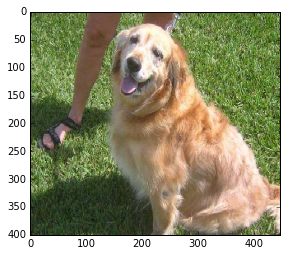

In [131]:

plt.imshow(first_rescale[0][num].transpose((1,2,0)))
num = num + 1

In [32]:
# We now create a "stream" over the dataset which will return shuffled batches
# of size 128. Using the DataStream instead of DataStream.default_stream constructor we return
# our images exactly as is.
stream = DataStream(
    train,
    iteration_scheme=ShuffledScheme(train.num_examples, 128)
)

# Our images are of different sizes, so we'll use a Fuel transformer
# to upscale images to at least (512,512)

upscale_stream = MinimumImageDimensions(stream, (256,256),which_sources=('image_features',))

# Take random crops of (32 x 32) from each image
cropped_stream = RandomFixedSizeCrop(
    upscale_stream, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
default_cropped_stream = ScaleAndShift(cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
default_flattened_stream = Flatten(
    default_cropped_stream, which_sources=('image_features',))
    



In [55]:
start_time = timeit.default_timer()
x, y = next(default_flattened_stream.get_epoch_iterator())
print(timeit.default_timer() - start_time)

0.6008042069151998


In [ ]:
# Let's load and process the dataset
from fuel.datasets.dogs_vs_cats import DogsVsCats
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
from fuel.transformers.image import RandomFixedSizeCrop
from fuel.transformers.image import MinimumImageDimensions
from fuel.transformers import Flatten
from fuel.transformers import ScaleAndShift
# Load the training set
train = DogsVsCats(('train',), subset=slice(0, 20000))


def create_data_stream():
    stream = DataStream(
        train,
        iteration_scheme=ShuffledScheme(train.num_examples, 128)
    )

    # Our images are of different sizes, so we'll use a Fuel transformer
    # to upscale images to at least (512,512)

    upscale_stream = MinimumImageDimensions(stream, (256,256),which_sources=('image_features',))

    return (upscale_stream)

In [1]:
from fuel.streams import ServerDataStream
data_stream = ServerDataStream(sources = ('image_features','target'),produces_examples=False)



In [2]:
data_stream.sources

('image_features', 'target')

In [3]:
iterator = data_stream.get_epoch_iterator() 
#print(timeit.default_timer() - start_time)

In [4]:
cur = next(iterator)

ValueError: cannot create an OBJECT array from memory buffer

In [54]:
data_stream

('image_features', 'target')

In [35]:
iterator=default_cropped_stream.get_epoch_iterator()

In [36]:
cur=next(iterator)

In [37]:
cur[1].shape

(128, 1)

In [38]:
cur[0][1].shape

(3, 32, 32)

In [4]:
import numpy


In [39]:
numpy.ndarray.max(cur[0][1])

0.74117647058823533

In [40]:
numpy.ndarray.min(cur[0][1])

0.45882352941176469

In [21]:
iterator=flattened_stream.get_epoch_iterator()
cur=next(iterator)
cur[0].shape

(128, 3072)

AttributeError: 'tuple' object has no attribute 'shape'

In [3]:
# Create the Theano MLP
import theano
from theano import tensor
import numpy

X = tensor.matrix('image_features')
T = tensor.lmatrix('targets')

W = theano.shared(
    numpy.random.uniform(low=-0.01, high=0.01, size=(3072, 128)), 'W')
b = theano.shared(numpy.zeros(128))
V = theano.shared(
    numpy.random.uniform(low=-0.01, high=0.01, size=(128, 2)), 'V')
c = theano.shared(numpy.zeros(2))
params = [W, b, V, c]

H = tensor.nnet.sigmoid(tensor.dot(X, W) + b)
Y = tensor.nnet.softmax(tensor.dot(H, V) + c)

loss = tensor.nnet.categorical_crossentropy(Y, T.flatten()).mean()


In [43]:
# Use Blocks to train this network
from blocks.algorithms import GradientDescent, Scale
from blocks.extensions import Printing
from blocks.extensions.monitoring import TrainingDataMonitoring
from blocks.main_loop import MainLoop

algorithm = GradientDescent(cost=loss, parameters=params,
                            step_rule=Scale(learning_rate=0.1))

# We want to monitor the cost as we train
loss.name = 'loss'
extensions = [TrainingDataMonitoring([loss], every_n_batches=1),
              Printing(every_n_batches=1)]

main_loop = MainLoop(data_stream=flattened_stream, algorithm=algorithm,
                     extensions=extensions)


In [46]:
algorithm.__class__

blocks.algorithms.GradientDescent

In [44]:
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 1
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1:
	 loss: 0.692895745014553


-------------------------------------------------------------------------------
-----------------------------------------


Blocks will complete this epoch of training and run extensions before exiting. If you do not want to complete this epoch, press CTRL + C again to stop training after the current batch.


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 224
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 224:
	 loss: 0.6915685126550596


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: True
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 225
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 225:
	 loss: 0.6940116329621606


-------------------------------------------------------------------------------
---------------------------

In [4]:
train_set = DogsVsCats(which_sets=('train',), subset=slice(0,20000))
valid_set = DogsVsCats(which_sets=('train',),subset=slice(20000,25000))
test_set = DogsVsCats(which_sets=('test',))

In [11]:
import numpy
import theano
from theano import tensor

# Size of the data 
n_in = 32 * 32 * 3
# Number of classes
n_out = 2

x = tensor.matrix('x')
W = theano.shared(value=numpy.zeros((n_in,n_out), dtype=theano.config.floatX), 
                  name='W',
                  borrow=True)
b = theano.shared(value=numpy.zeros((n_out,), dtype=theano.config.floatX),
                  name='W',
                  borrow=True)

In [12]:
p_y_given_x = tensor.nnet.softmax(tensor.dot(x,W)+b)
y_pred = tensor.argmax(p_y_given_x, axis=1)

In [13]:
y = tensor.lvector('y')
log_prob = tensor.log(p_y_given_x)
log_likelihood = log_prob[tensor.arange(y.shape[0]),y]
loss = -log_likelihood.mean()

In [14]:
g_W, g_b = theano.grad(cost=loss,wrt=[W,b])

In [15]:
learning_rate = numpy.float32(0.13)
new_W = W - learning_rate * g_W
new_b = b - learning_rate * g_b


In [16]:
train_model = theano.function(inputs=[x,y],
                              outputs=loss,
                              updates=[(W, new_W),
                                       (b, new_b)])

In [12]:
misclass_nb = tensor.neq(y_pred, y)
misclass_rate = misclass_nb.mean()

test_model = theano.function(inputs=[x,y],
                             outputs=misclass_rate)

In [13]:
import timeit
## Define a couple of helper variables and functions for the optimization
batch_size = 500
n_train_batches = train.num_examples // batch_size



In [18]:
from fuel.streams import ServerDataStream
train_stream = ServerDataStream(('image_features', 'target'),port = 5557, produces_examples = False)



In [19]:
iterator = train_stream.get_epoch_iterator()
cur = next(iterator)

In [20]:
minibatch_xi, minibatch_yi = cur

In [21]:
minibatch_xi.shape

(16, 3072)

In [31]:
minibatch_yi.flatten().shape

(128,)

In [22]:
minibatch_avg_cost = train_model(minibatch_xi,minibatch_yi.flatten())

In [23]:
minibatch_avg_cost

array(0.6931471805599453)

In [26]:
import timeit
start_time = 0
for minibatch_x, minibatch_y in train_stream.get_epoch_iterator():
    get_time = timeit.default_timer() - start_time
    start_time = timeit.default_timer()
    minibatch_avg_cost = train_model(minibatch_x, minibatch_y.flatten())
    print("train time is {}, get time is {}".format(timeit.default_timer()-start_time,get_time))
    start_time = timeit.default_timer()

train time is 0.0007381539326161146, get time is 632431.750816348
train time is 0.0006954859709367156, get time is 0.0003151580458506942
train time is 0.0005820139776915312, get time is 0.00046163599472492933
train time is 0.0006352659547701478, get time is 0.00029521400574594736
train time is 0.0007442820351570845, get time is 0.0002914280630648136
train time is 0.0006277859210968018, get time is 0.0003660980146378279
train time is 0.0007362120086327195, get time is 0.0005112800281494856
train time is 0.0007392179686576128, get time is 0.0006272220052778721
train time is 0.001739976927638054, get time is 5.731413361034356
train time is 0.0012899230932816863, get time is 0.000474205007776618
train time is 0.0007851599948480725, get time is 0.00030818500090390444
train time is 0.0007363850018009543, get time is 0.00048112496733665466
train time is 0.000605089939199388, get time is 0.0005031169857829809
train time is 0.0006438560085371137, get time is 0.0006830641068518162
train time is 

In [27]:
20000/16.*0.05

62.5

Data stream for validating set

In [15]:
# We now create a "stream" over the dataset which will return shuffled batches
# of size 128. Using the DataStream instead of DataStream.default_stream constructor we return
# our images exactly as is.
valid_stream = DataStream(
    valid_set,
    iteration_scheme=ShuffledScheme(valid_set.num_examples, 128)
)

# Our images are of different sizes, so we'll use a Fuel transformer
# to upscale images to at least (512,512)

valid_upscale_stream = MinimumImageDimensions(valid_stream, (512,512),which_sources=('image_features',))

# Take random crops of (32 x 32) from each image
valid_cropped_stream = RandomFixedSizeCrop(
    valid_upscale_stream, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
valid_default_cropped_stream = ScaleAndShift(valid_cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
valid_flattened_stream = Flatten(
    valid_default_cropped_stream, which_sources=('image_features',))
    




Data stream for test set.

In [16]:
# We now create a "stream" over the dataset which will return shuffled batches
# of size 128. Using the DataStream instead of DataStream.default_stream constructor we return
# our images exactly as is.
test_stream = DataStream(
    test_set,
    iteration_scheme=ShuffledScheme(test_set.num_examples, 128)
)

# Our images are of different sizes, so we'll use a Fuel transformer
# to upscale images to at least (512,512)

test_upscale_stream = MinimumImageDimensions(test_stream, (512,512),which_sources=('image_features',))

# Take random crops of (32 x 32) from each image
test_cropped_stream = RandomFixedSizeCrop(
    test_upscale_stream, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
test_default_cropped_stream = ScaleAndShift(test_cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
test_flattened_stream = Flatten(
    test_default_cropped_stream, which_sources=('image_features',))
    




In [17]:
## early stopping parameters 
# maximum number of epochs
n_epochs =50
# look at this many samples regardless
patience = 2000
# wait this much longer when a new best is found
patience_increase = 2
# a relative improvement of this much is considered significant
improvement_threshold = 0.995
# go through this many minibatches before checking the network on the validation set;
# in this case we check every epoch
validation_frequency = min(n_train_batches, patience / 2)

In [18]:
best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0
while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    minibatch_index = 0 
    for minibatch_x,minibatch_y in train_stream.get_epoch_iterator():
        minibatch_avg_cost = train_model(minibatch_x,minibatch_y.flatten())
        
        # iteration number
        iter = (epoch -1)*n_train_batches + minibatch_index
        if (iter + 1) % validation_frequency == 0:
            validation_losses = []
            for valid_xi, valid_yi in valid_flattened_stream.get_epoch_iterator():
                validation_losses.append(test_model(valid_xi, valid_yi.flatten()))
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch,
                   minibatch_index +1,
                   n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now 
            if this_validation_loss < best_validation_loss:
                # improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss
            
            # test it on the test set 
            test_losses = []
            for test_xi, test_yi in test_flattened_stream.get_epoch_iterator():
                test_losses.append(test_model(test_xi,test_yi.flatten()))
                
            test_score = numpy.mean(test_losses)
            print('  epoch %i, minibatch %i/%i, test error of best model %f %%' %
                  (epoch,
                   minibatch_index + 1,
                   n_train_batches,
                   test_score * 100.))
            
            # save the best parameter
            numpy.savez('best_model.npz',W=W.get_value(),b=b.get_value())
        
        minibatch_index +=1
        if patience <= iter:
            done_looping = True
            break
    
end_time = timeit.default_timer()
print('Optimization complete with best validation score of %f %%,'
      'with test performance %f %%' %
          (best_validation_loss * 100., test_score * 100.))
print('The code ran for %d epochs, with %f epochs/sec' %
      (epoch, 1. * epoch/(end_time-start_time)))

KeyboardInterrupt: 

In [28]:
iterator = valid_flattened_stream.get_epoch_iterator()
cur = next(iterator)
valid_xi, valid_yi = cur

In [29]:
valid_xi

array([[ 0.39215686,  0.38039216,  0.38039216, ...,  0.49019608,
         0.49411765,  0.55686275],
       [ 0.29019608,  0.18431373,  0.18431373, ...,  0.1372549 ,
         0.1372549 ,  0.23529412],
       [ 0.05882353,  0.07058824,  0.07058824, ...,  0.02352941,
         0.02352941,  0.02352941],
       ..., 
       [ 0.76862745,  0.77254902,  0.74901961, ...,  0.61176471,
         0.59607843,  0.57647059],
       [ 0.32941176,  0.32941176,  0.28627451, ...,  0.23137255,
         0.23137255,  0.14509804],
       [ 0.44705882,  0.52941176,  0.52941176, ...,  0.45882353,
         0.45882353,  0.55686275]])

In [30]:
out = test_model(valid_xi, valid_yi.flatten())

In [ ]:
learning_rate.dtype

In [2]:
import numpy
learning_rate=numpy.float32(0.12)
learning_rate.dtype

dtype('float32')

In [19]:
    epoch = epoch + 1
    minibatch_index = 0 
    for minibatch_x,minibatch_y in train_stream.get_epoch_iterator():
        minibatch_avg_cost = train_model(minibatch_x,minibatch_y.flatten())
        
        # iteration number
        iter = (epoch -1)*n_train_batches + minibatch_index
        if (iter + 1) % validation_frequency == 0:
            validation_losses = []
            for valid_xi, valid_yi in valid_flattened_stream.get_epoch_iterator():
                validation_losses.append(test_model(valid_xi, valid_yi.flatten()))
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch,
                   minibatch_index +1,
                   n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now 
            if this_validation_loss < best_validation_loss:
                # improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss
            
            # test it on the test set 
            test_losses = []
            for test_xi, test_yi in test_flattened_stream.get_epoch_iterator():
                test_losses.append(test_model(test_xi,test_yi.flatten()))
                
            test_score = numpy.mean(test_losses)
            print('  epoch %i, minibatch %i/%i, test error of best model %f %%' %
                  (epoch,
                   minibatch_index + 1,
                   n_train_batches,
                   test_score * 100.))
            



KeyboardInterrupt: 

In [4]:
import os
import timeit

#os.environ['FUEL_DATA_PATH'] = os.path.abspath('./fuel_data')

# Let's load and process the dataset
from fuel.datasets.dogs_vs_cats import DogsVsCats
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
from fuel.transformers.image import RandomFixedSizeCrop
from fuel.transformers.image import MinimumImageDimensions
from fuel.transformers import Flatten
from fuel.transformers import ScaleAndShift


train_set = DogsVsCats(('train',), subset=slice(0, 20000))
valid_set = DogsVsCats(('train',), subset=slice(20000, 25000))
test_set = DogsVsCats(('test',))

batch_size = 16
n_train_batches = train_set.num_examples // batch_size

#################################################################################
# Train Stream
# We now create a "stream" over the dataset which will return shuffled batches
# of size 128. Using the DataStream instead of DataStream.default_stream constructor we return
# our images exactly as is.
stream = DataStream(
    train_set,
    iteration_scheme=ShuffledScheme(train_set.num_examples, batch_size)
)

# Our images are of different sizes, so we'll use a Fuel transformer
# to upscale images to at least (512 x 512)

upscale_stream = MinimumImageDimensions(stream, (512,512),which_sources=('image_features',))

# Take random crops of (32 x 32) from each image
cropped_stream = RandomFixedSizeCrop(
    upscale_stream, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
default_cropped_stream = ScaleAndShift(cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
train_stream = Flatten(
    default_cropped_stream, which_sources=('image_features',))
    
######################################################################################
# Valid Stream

# We now create a "stream" over the dataset which will return shuffled batches
# of size 128. Using the DataStream instead of DataStream.default_stream constructor we return
# our images exactly as is.
stream = DataStream(
    valid_set,
    iteration_scheme=ShuffledScheme(valid_set.num_examples, batch_size)
)

# Our images are of different sizes, so we'll use a Fuel transformer
# to upscale images to at least (512,512)

valid_upscale_stream = MinimumImageDimensions(stream, (512,512),which_sources=('image_features',))

# Take random crops of (32 x 32) from each image
valid_cropped_stream = RandomFixedSizeCrop(
    valid_upscale_stream, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
valid_default_cropped_stream = ScaleAndShift(valid_cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
valid_stream = Flatten(
    valid_default_cropped_stream, which_sources=('image_features',))
    
##########################################################################################
# Test Stream 

# We now create a "stream" over the dataset which will return shuffled batches
# of size 128. Using the DataStream instead of DataStream.default_stream constructor we return
# our images exactly as is.
stream = DataStream(
    test_set,
    iteration_scheme=ShuffledScheme(test_set.num_examples, batch_size)
)

# Our images are of different sizes, so we'll use a Fuel transformer
# to upscale images to at least (512,512)

test_upscale_stream = MinimumImageDimensions(stream, (512,512),which_sources=('image_features',))

# Take random crops of (32 x 32) from each image
test_cropped_stream = RandomFixedSizeCrop(
    test_upscale_stream, (32, 32), which_sources=('image_features',))

# Convert images to [0,1] scale
test_default_cropped_stream = ScaleAndShift(test_cropped_stream,  1.0/(255.0), 0., which_sources=('image_features',))
# We'll use a simple MLP, so we need to flatten the images
# from (channel, width, height) to simply (features,)
test_stream = Flatten(
    test_default_cropped_stream, which_sources=('image_features',))
    
####################################################################################################


In [29]:
import numpy
import theano
from theano import tensor

batch_size = 16

# Size of the data
n_in = 32 * 32 * 3 
# Number of classes
n_out = 2

x = tensor.matrix('x')
W = theano.shared(value=numpy.zeros((n_in, n_out), dtype=theano.config.floatX),
                  name='W',
                  borrow=True)
b = theano.shared(value=numpy.zeros((n_out,), dtype=theano.config.floatX),
                  name='b',
                  borrow=True)
                  
p_y_given_x = tensor.nnet.softmax(tensor.dot(x, W) + b)
y_pred = tensor.argmax(p_y_given_x, axis=1)

y = tensor.lvector('y')
log_prob = tensor.log(p_y_given_x)
log_likelihood = log_prob[tensor.arange(y.shape[0]), y]
loss = - log_likelihood.mean()

g_W, g_b = theano.grad(cost=loss, wrt=[W, b])

learning_rate = numpy.float32(0.13)
new_W = W - learning_rate * g_W
new_b = b - learning_rate * g_b

train_model = theano.function(inputs=[x, y],
                              outputs=loss,
                              updates=[(W, new_W),
                                       (b, new_b)])
                                       

misclass_nb = tensor.neq(y_pred, y)
misclass_rate = misclass_nb.mean()

test_model = theano.function(inputs=[x, y],
                             outputs=misclass_rate)

In [30]:
batch_size = 16
#n_train_batches = train_set.num_examples // batch_size
n_train_batches = 20000 // batch_size

from fuel.streams import ServerDataStream

## early stopping parameters 
# maximum number of epochs
n_epochs = 1000
# look at this many samples regardless
patience = 5000
# wait this much longer when a new best is found
patience_increase = 2
# a relative improvement of this much is considered significant
improvement_threshold = 0.995
# go through this many minibatches before checking the network on the validation set;
# in this case we check every epoch
validation_frequency = min(n_train_batches, patience / 2)


best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0

train_stream = ServerDataStream(('image_features', 'target'),port = 5557, produces_examples = False)
valid_stream = ServerDataStream(('image_features', 'target'),port = 5558, produces_examples= False)
test_stream = ServerDataStream(('image_features', 'target'),port = 5559, produces_examples= False)
while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    minibatch_index = 0
    epoch_train_start_time = timeit.default_timer()
    for minibatch_x, minibatch_y in train_stream.get_epoch_iterator():
        minibatch_avg_cost = train_model(minibatch_x, minibatch_y.flatten())
        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = []
            for valid_xi, valid_yi in valid_stream.get_epoch_iterator():
                validation_losses.append(test_model(valid_xi, valid_yi.flatten()))
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch,
                   minibatch_index + 1,
                   n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss

                # test it on the test set
                test_losses = []
                for test_xi, test_yi in test_stream.get_epoch_iterator():
                    test_losses.append(test_model(test_xi, test_yi.flatten()))

                test_score = numpy.mean(test_losses)
                print('     epoch %i, minibatch %i/%i, test error of best model %f %%' %
                      (epoch,
                       minibatch_index + 1,
                       n_train_batches,
                       test_score * 100.))

                # save the best parameters
                numpy.savez('best_model.npz', W=W.get_value(), b=b.get_value())
        
        minibatch_index += 1
        if patience <= iter:
            done_looping = True
            break
    
    epoch_train_time = timeit.default_timer() - epoch_train_start_time
    print("iteration {}, train time {}".format(epoch,epoch_train_time))

end_time = timeit.default_timer()
print('Optimization complete with best validation score of %f %%, '
      'with test performance %f %%' %
      (best_validation_loss * 100., test_score * 100.))

print('The code ran for %d epochs, with %f epochs/sec' %
      (epoch, 1. * epoch / (end_time - start_time)))

iteration 1, train time 65.15433682792354
epoch 2, minibatch 1250/1250, validation error 50.119808 %
     epoch 2, minibatch 1250/1250, test error of best model 7.720588 %
iteration 2, train time 124.49284557194915
epoch 3, minibatch 1250/1250, validation error 50.339457 %
iteration 3, train time 81.10199805605225


KeyboardInterrupt: 

In [34]:
W.get_value()[10:20,]

array([[ 0.11766954, -0.11766954],
       [ 0.18450263, -0.18450263],
       [ 0.22792877, -0.22792877],
       [ 0.00077075, -0.00077075],
       [ 0.02942561, -0.02942561],
       [-0.00037794,  0.00037794],
       [ 0.05102173, -0.05102173],
       [ 0.0804609 , -0.0804609 ],
       [ 0.13970691, -0.13970691],
       [ 0.19132053, -0.19132053]])

In [37]:
b.get_value()

array([ 0.88276773, -0.88276773])

In [4]:
iterator = train_stream.get_epoch_iterator()

In [5]:
minibatch_x, minibatch_y = next(iterator)

In [6]:
minibatch_avg_cost = train_model(minibatch_x, minibatch_y.flatten())

array(0.6931471805599462)

In [8]:
iterator = valid_stream.get_epoch_iterator()
valid_xi, valid_yi = next(iterator)

In [9]:
temp = test_model(valid_xi, valid_yi.flatten())

In [10]:
temp

array(0.484375)

In [12]:
iter = (epoch - 1) * n_train_batches + 0

In [13]:
iter

-156

In [14]:
epoch

0

In [15]:
epoch = epoch + 1
minibatch_index = 0
iter = (epoch - 1) * n_train_batches + minibatch_index

In [16]:
(iter + 1) % validation_frequency == 0

False

In [17]:
validation_frequency

156

In [18]:
iter

0

In [4]:
start_time = timeit.default_timer()



In [5]:
start_time

531840.165673581

In [6]:
timeit.default_timer()-start_time

18.77587145799771

In [7]:
print("iteration {}, train time {}".format(iter,1))

iteration 155, train time 1


In [1]:
import timeit
from fuel.streams import ServerDataStream

In [2]:
train_stream = ServerDataStream(('image_features','target'),produces_examples=False,hwm=50)

In [ ]:
prev_time = timeit.default_timer()
total_time = 0 
for minibatch_x, minibatch_y in train_stream.get_epoch_iterator():
    total_time = total_time + timeit.default_timer() - prev_time
    prev_time = timeit.default_timer()
    print("processing time for minibatch {}".format(total_time))

In [ ]:
prev_time = timeit.default_timer()
total_time = 0 
for minibatch_x, minibatch_y in train_stream.get_epoch_iterator():
    total_time = total_time + timeit.default_timer() - prev_time
    prev_time = timeit.default_timer()
    print("processing time for minibatch {}".format(total_time))

processing time for minibatch 0.004950297996401787
processing time for minibatch 0.007797711994498968
processing time for minibatch 0.014436658006161451
processing time for minibatch 0.02027149999048561
processing time for minibatch 0.024197579943574965
processing time for minibatch 0.02679710788652301
processing time for minibatch 0.029288047924637794
processing time for minibatch 1.0867891740053892
processing time for minibatch 2.873692714027129
processing time for minibatch 4.516100308042951
processing time for minibatch 6.141449692077003
processing time for minibatch 7.86949675809592
processing time for minibatch 9.74173909612
processing time for minibatch 11.664434968028218
processing time for minibatch 13.6735487281112
processing time for minibatch 15.380913712084293
processing time for minibatch 17.083761926041916
processing time for minibatch 18.735602018074133
processing time for minibatch 20.384450579062104
processing time for minibatch 22.016618694062345
processing time for 